In [45]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from keras.models import Model
from keras.layers import GRU, Concatenate, Input, Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

modelList = []
history = []
xaxis = []  
refit_history = []
refit_xaxis = []
    
import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.start = time.time()
    #def on_epoch_begin(self, batch, logs={}):
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.start)
        
from keras.callbacks import Callback
class TimedStopping(Callback):
    '''Stop training when enough time has passed.
    # Arguments
        seconds: maximum time before stopping.
        verbose: verbosity mode.
    '''
    def __init__(self, seconds=None, verbose=0):
        super(Callback, self).__init__()

        self.start_time = 0
        self.seconds = seconds
        self.verbose = verbose
    def on_train_begin(self, logs={}):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs={}):
        if time.time() - self.start_time > self.seconds:
            self.model.stop_training = True
            if self.verbose:
                print('Stopping after %s seconds.' % self.seconds)
                
def Plot(i, text = 'acc', label = ''):
    plt.plot(xaxis[i], history[i].history['val_'+text], label = label)
def Plot2(i, j, text = 'acc', label = ''):
    plt.plot(xaxis[i]+[t+xaxis[i][-1] for t in refit_xaxis[j]]
             , history[i].history['val_'+text]+refit_history[j].history['val_'+text], label = label)

# Already done, do not do again

In [2]:
weatherData = np.concatenate((np.load('weatherData1991.npy'),np.load('FullweatherData.npy'),np.load('weatherData2000_04.npy'),
                             np.load('weatherData2005_09.npy'),np.load('weatherData2010_15.npy')))
df = (pd.DataFrame(np.load('NewFireData.npy'), columns=['day', 'lat', 'lon', 'num_cause', 'tarray', 'xybinarray', 'fire'])
      .drop('num_cause',axis=1).astype(int, copy=False))

def moddf(df):
    df0 = df.drop(['tarray', 'xybinarray'],axis=1).values
    df0 = (df0-df0.mean())/ df0.std()
    
    tarray = df['tarray'].values
    xybinarray = df['xybinarray'].values
    df1 = np.empty((len(df),31,4))
    for i in range(0,31):
        for j in range(0,4):
            df1[:,i,j] = weatherData[tarray-i, xybinarray,j]
    # Normalize features
    df1 = (df1-df1.mean())/ df1.std()
    
    return df0, df1

xdf = df.drop('fire',axis=1)
y = df['fire'].values
x0, x1 = moddf(xdf)
X0, X0_test, X1, X1_test, y, y_test = train_test_split(
    x0, x1, y, test_size=0.1, shuffle=True)
X0_train, X0_val, X1_train, X1_val, y_train, y_val = train_test_split(
    X0, X1, y, test_size=0.1, shuffle=True)

np.save('X0_train', X0_train, allow_pickle=True, fix_imports=False)
np.save('X1_train', X1_train, allow_pickle=True, fix_imports=False)
np.save('y_train', y_train, allow_pickle=True, fix_imports=False)
np.save('X0_val', X0_val, allow_pickle=True, fix_imports=False)
np.save('X1_val', X1_val, allow_pickle=True, fix_imports=False)
np.save('y_val', y_val, allow_pickle=True, fix_imports=False)
np.save('X0_test', X0_test, allow_pickle=True, fix_imports=False)
np.save('X1_test', X1_test, allow_pickle=True, fix_imports=False)
np.save('y_test', y_test, allow_pickle=True, fix_imports=False)

# Load data

In [2]:
X0_train = np.load('X0_train.npy', mmap_mode='r')
X1_train = np.load('X1_train.npy', mmap_mode='r')
y_train = np.load('y_train.npy', mmap_mode='r')
X0_val = np.load('X0_val.npy')
X1_val = np.load('X1_val.npy')
y_val = np.load('y_val.npy')
X0_test = np.load('X0_test.npy')
X1_test = np.load('X1_test.npy')
y_test = np.load('y_test.npy')

length_train = 2973745
indices = np.arange(length_train, dtype=int)

def generator(batchSize=512):
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(indices), batchSize):
            batch_indices = indices[i:i+batchSize]
            batch_indices.sort()

            bx0 = X0_train[batch_indices,...]
            bx1 = X1_train[batch_indices,...]
            by = y_train[batch_indices,...]

            yield ([bx0,bx1], by)

# Train neuronet (GRU)

In [4]:
def fit(nUnits, batchSize, timelimit, nlayer):
    x0 = Input(shape=(3,)) # location and day
    x1 = Input(shape=(31,4)) # weather
    # first
    inistate = Dense(nUnits, activation = 'relu')(x0)
    x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
    # nlayer middle layers
    for _ in range(nlayer): 
        inistate = Dense(nUnits, activation = 'relu')(inistate)
        x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
    # last
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[x0,x1], outputs=x)
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit_generator(generator(batchSize),steps_per_epoch = 2973745//batchSize
                                        ,epochs=100, verbose=2, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping]))
    xaxis.append(time_callback.times)
    modelList.append(model) 
    
def refit(batchsize, timelimit, model, patience):
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    es = EarlyStopping(monitor='val_loss', min_delta=0., patience=patience)
    refit_history.append(modelList[model].fit_generator(generator(batchsize),steps_per_epoch = 2973745//batchsize
                                        ,epochs=200, verbose=2, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping, es]))
    refit_xaxis.append(time_callback.times)

In [16]:
fit(nUnits = 80, batchSize = 1024, timelimit = 300, nlayer = 1)

Epoch 1/100
5045s - loss: 0.6269 - acc: 0.6348 - val_loss: 0.6086 - val_acc: 0.6635


So the accuracy is very low after 5045 s (1.4 hours).

With less fires, I had an accuracy of 71% after 4000 s. Correlation in time might be useful and now it's harder to learn them because it's on more years.

Hopefully, it'll get better with more epochs.

Python is using 2.6 GB right now even with the generator. I should look what makes the memory usage.

In [22]:
# !!! Already done

modelList[0].save('my_model5045.h5')
# try save weight in case saving model doesn't work
modelList[0].save_weights('my_model_weights5045.h5')

In [5]:
from keras.models import load_model
model = load_model('my_model5045.h5')

ValueError: Layer gru_13 expects 1 inputs, but it received 2 input tensors. Input received: [<tf.Tensor 'input_10:0' shape=(?, 31, 4) dtype=float32>, <tf.Tensor 'dense_17/Relu:0' shape=(?, 80) dtype=float32>]

In [7]:
# In case it doesn't work
def fit_loadweight(nUnits, batchSize, timelimit, nlayer):
    x0 = Input(shape=(3,)) # location
    x1 = Input(shape=(31,4)) # weather
    # first
    inistate = Dense(nUnits, activation = 'relu')(x0)
    x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
    # nlayer middle layers
    for _ in range(nlayer): 
        inistate = Dense(nUnits, activation = 'relu')(inistate)
        x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
    # last
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[x0,x1], outputs=x)
    model.load_weights('my_model_weights5045.h5')
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit_generator(generator(batchSize),steps_per_epoch = 2973745//batchSize
                                        ,epochs=100, verbose=2, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping]))
    xaxis.append(time_callback.times)
    modelList.append(model)
    
fit_loadweight(nUnits = 80, batchSize = 1024, timelimit = 4*3600, nlayer = 1)

Epoch 1/100
1328s - loss: 0.6020 - acc: 0.6695 - val_loss: 0.5962 - val_acc: 0.6770
Epoch 2/100
582s - loss: 0.5928 - acc: 0.6782 - val_loss: 0.5904 - val_acc: 0.6811
Epoch 3/100
583s - loss: 0.5891 - acc: 0.6809 - val_loss: 0.5891 - val_acc: 0.6817
Epoch 4/100
582s - loss: 0.5866 - acc: 0.6830 - val_loss: 0.5867 - val_acc: 0.6826
Epoch 5/100
581s - loss: 0.5846 - acc: 0.6844 - val_loss: 0.5878 - val_acc: 0.6816
Epoch 6/100
581s - loss: 0.5830 - acc: 0.6855 - val_loss: 0.5834 - val_acc: 0.6855
Epoch 7/100
584s - loss: 0.5814 - acc: 0.6869 - val_loss: 0.5821 - val_acc: 0.6861
Epoch 8/100
582s - loss: 0.5798 - acc: 0.6879 - val_loss: 0.5832 - val_acc: 0.6860
Epoch 9/100
581s - loss: 0.5786 - acc: 0.6887 - val_loss: 0.5837 - val_acc: 0.6845
Epoch 10/100
583s - loss: 0.5773 - acc: 0.6898 - val_loss: 0.5801 - val_acc: 0.6871
Epoch 11/100
583s - loss: 0.5762 - acc: 0.6905 - val_loss: 0.5795 - val_acc: 0.6886
Epoch 12/100
585s - loss: 0.5749 - acc: 0.6916 - val_loss: 0.5782 - val_acc: 0.6892


The 5045s for the 1st epoch was probably inacurate. Most likely my computer went to sleep during the calculation.

However, the accuracy is very low.

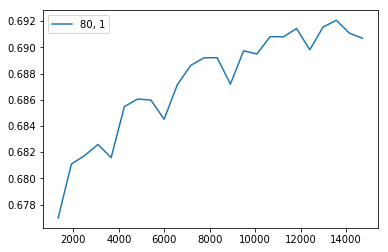

In [11]:
Plot(0, 'acc', '80, 1')
plt.legend()

# It is still going up so we could improve it by training longer.

In [13]:
modelList[0].save_weights('my_model_weights14k.h5')

# Use fully connected neuronet

In [3]:
from keras.layers import Multiply, Concatenate, Reshape, Flatten

def fit(nUnitsPos,nlayerPos, nUnits, nlayer, batchSize, timelimit):
    x0 = Input(shape=(3,)) # location and day
    x1 = Input(shape=(31,4)) # weather
    
    y0 = Dense(nUnitsPos, activation = 'relu')(x0) # 1st layer position
    for _ in range(nlayerPos): # learn a better position representation
        y0 = Dense(nUnitsPos, activation = 'relu')(y0)
    
    a = Dense(31*4, activation = 'relu')(y0) # attention on weather
    a = Reshape((31,4))(a)
    y1 = Multiply()([x1,a])
    y1 = Flatten()(y1)
    y = Concatenate()([y0,y1]) # combine position and weather information
    
    for _ in range(nlayer):
        y = Dense(nUnits, activation = 'relu')(y)
    
    y = Dense(1, activation='sigmoid')(y)

    model = Model(inputs=[x0,x1], outputs=y)
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit_generator(generator(batchSize),steps_per_epoch = 2973745//batchSize
                                        ,epochs=100, verbose=2, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping]))
    xaxis.append(time_callback.times)
    modelList.append(model) 
    
def refit(batchsize, timelimit, model):
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    es = EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    refit_history.append(model.fit_generator(generator(batchSize),steps_per_epoch = 2973745//batchSize
                                        ,epochs=200, batch_size=batchsize,verbose=2, shuffle=True, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping, es]))
    refit_xaxis.append(time_callback.times)

In [4]:
fit(nUnitsPos = 10,nlayerPos = 0, nUnits = 40, nlayer = 1, batchSize = 256, timelimit = 300)

Epoch 1/100
3656s - loss: 0.6253 - acc: 0.6439 - val_loss: 0.6134 - val_acc: 0.6592


In [6]:
# Strongly increase batchsize, use around 37% of GPU and CPU, but during the 1st epoch in which it's around 1%.

fit(nUnitsPos = 10,nlayerPos = 0, nUnits = 80, nlayer = 1, batchSize = 5000, timelimit = 3600)

Epoch 1/100
91s - loss: 0.6498 - acc: 0.6074 - val_loss: 0.6324 - val_acc: 0.6377
Epoch 2/100
7s - loss: 0.6268 - acc: 0.6431 - val_loss: 0.6243 - val_acc: 0.6486
Epoch 3/100
8s - loss: 0.6216 - acc: 0.6496 - val_loss: 0.6213 - val_acc: 0.6512
Epoch 4/100
8s - loss: 0.6185 - acc: 0.6527 - val_loss: 0.6176 - val_acc: 0.6544
Epoch 5/100
8s - loss: 0.6157 - acc: 0.6555 - val_loss: 0.6153 - val_acc: 0.6566
Epoch 6/100
8s - loss: 0.6134 - acc: 0.6581 - val_loss: 0.6132 - val_acc: 0.6596
Epoch 7/100
8s - loss: 0.6113 - acc: 0.6602 - val_loss: 0.6113 - val_acc: 0.6624
Epoch 8/100
8s - loss: 0.6095 - acc: 0.6624 - val_loss: 0.6096 - val_acc: 0.6629
Epoch 9/100
7s - loss: 0.6079 - acc: 0.6644 - val_loss: 0.6081 - val_acc: 0.6648
Epoch 10/100
7s - loss: 0.6065 - acc: 0.6662 - val_loss: 0.6067 - val_acc: 0.6666
Epoch 11/100
8s - loss: 0.6050 - acc: 0.6681 - val_loss: 0.6055 - val_acc: 0.6679
Epoch 12/100
7s - loss: 0.6038 - acc: 0.6694 - val_loss: 0.6043 - val_acc: 0.6694
Epoch 13/100
8s - loss: 

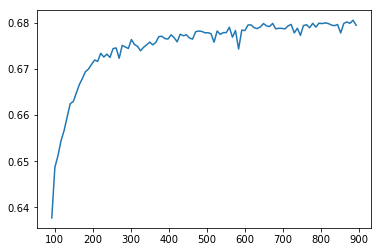

In [7]:
Plot(1, 'acc')

# I got 0.68 which is less than what I got from GRU 0.71 or XGBoost 0.72
# However, I might do better by using a more complex model.

In [8]:
fit(nUnitsPos = 20,nlayerPos = 1, nUnits = 160, nlayer = 3, batchSize = 5000, timelimit = 900)

Epoch 1/100
12s - loss: 0.6329 - acc: 0.6320 - val_loss: 0.6180 - val_acc: 0.6558
Epoch 2/100
11s - loss: 0.6104 - acc: 0.6631 - val_loss: 0.6058 - val_acc: 0.6678
Epoch 3/100
11s - loss: 0.6032 - acc: 0.6698 - val_loss: 0.6011 - val_acc: 0.6713
Epoch 4/100
11s - loss: 0.5998 - acc: 0.6727 - val_loss: 0.5985 - val_acc: 0.6741
Epoch 5/100
11s - loss: 0.5978 - acc: 0.6743 - val_loss: 0.5997 - val_acc: 0.6724
Epoch 6/100
11s - loss: 0.5959 - acc: 0.6757 - val_loss: 0.5979 - val_acc: 0.6733
Epoch 7/100
11s - loss: 0.5951 - acc: 0.6762 - val_loss: 0.5963 - val_acc: 0.6750
Epoch 8/100
11s - loss: 0.5939 - acc: 0.6773 - val_loss: 0.5957 - val_acc: 0.6744
Epoch 9/100
11s - loss: 0.5928 - acc: 0.6782 - val_loss: 0.5940 - val_acc: 0.6764
Epoch 10/100
11s - loss: 0.5924 - acc: 0.6785 - val_loss: 0.5929 - val_acc: 0.6778
Epoch 11/100
11s - loss: 0.5912 - acc: 0.6792 - val_loss: 0.5944 - val_acc: 0.6768
Epoch 12/100
11s - loss: 0.5908 - acc: 0.6798 - val_loss: 0.5925 - val_acc: 0.6772
Epoch 13/100


Now it's 35% CPU, and GPU between 38% and 52%

Model 2 (20,1,160,3) is more complex than model 1 (10,0,80,1) and both use the same batchSize of 5000 so it's strange that the 1st epoch of model 1 be longer than the one of model 2 (91 s vs 12 s). Afterwards, it's normal with (8 s vs 11 s).

It's not because model 1 was the first and there was some more compilation to do since I did model 0 before, unless the compilation had to be done again because I closed my computer, but I did not between model 1 and 2.

It's worth to be explored so I don't get too long 1st epoch. Also, I should not take count of it while comparing the plots.

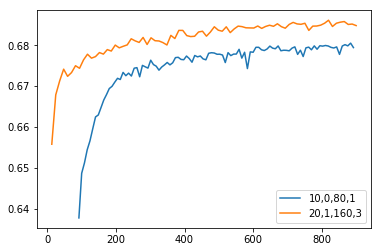

In [14]:
Plot(1, 'acc', '10,0,80,1')
Plot(2, 'acc', '20,1,160,3')
plt.legend();

In [15]:
# change batchsize

fit(nUnitsPos = 20,nlayerPos = 1, nUnits = 160, nlayer = 3, batchSize = 1024, timelimit = 300)

Epoch 1/100
27s - loss: 0.6198 - acc: 0.6511 - val_loss: 0.6075 - val_acc: 0.6666
Epoch 2/100
26s - loss: 0.6030 - acc: 0.6700 - val_loss: 0.6016 - val_acc: 0.6714
Epoch 3/100
26s - loss: 0.5989 - acc: 0.6732 - val_loss: 0.5962 - val_acc: 0.6752
Epoch 4/100
26s - loss: 0.5968 - acc: 0.6750 - val_loss: 0.5975 - val_acc: 0.6746
Epoch 5/100
26s - loss: 0.5947 - acc: 0.6767 - val_loss: 0.5952 - val_acc: 0.6755
Epoch 6/100
26s - loss: 0.5931 - acc: 0.6779 - val_loss: 0.5924 - val_acc: 0.6781
Epoch 7/100
26s - loss: 0.5917 - acc: 0.6789 - val_loss: 0.5945 - val_acc: 0.6760
Epoch 8/100
26s - loss: 0.5907 - acc: 0.6796 - val_loss: 0.5922 - val_acc: 0.6784
Epoch 9/100
26s - loss: 0.5894 - acc: 0.6808 - val_loss: 0.5915 - val_acc: 0.6791
Epoch 10/100
26s - loss: 0.5885 - acc: 0.6817 - val_loss: 0.5912 - val_acc: 0.6788
Epoch 11/100
26s - loss: 0.5875 - acc: 0.6820 - val_loss: 0.5891 - val_acc: 0.6806
Epoch 12/100
26s - loss: 0.5868 - acc: 0.6825 - val_loss: 0.5894 - val_acc: 0.6803


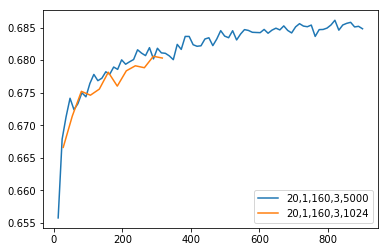

In [17]:
Plot(2, 'acc', '20,1,160,3,5000')
Plot(3, 'acc', '20,1,160,3,1024')
plt.legend();

In [18]:
fit(nUnitsPos = 20,nlayerPos = 1, nUnits = 160, nlayer = 5, batchSize = 5000, timelimit = 900)

Epoch 1/100
15s - loss: 0.6254 - acc: 0.6421 - val_loss: 0.6082 - val_acc: 0.6659
Epoch 2/100
13s - loss: 0.6035 - acc: 0.6696 - val_loss: 0.6002 - val_acc: 0.6736
Epoch 3/100
13s - loss: 0.5979 - acc: 0.6744 - val_loss: 0.5983 - val_acc: 0.6736
Epoch 4/100
13s - loss: 0.5945 - acc: 0.6772 - val_loss: 0.5929 - val_acc: 0.6775
Epoch 5/100
13s - loss: 0.5924 - acc: 0.6787 - val_loss: 0.5942 - val_acc: 0.6766
Epoch 6/100
13s - loss: 0.5907 - acc: 0.6801 - val_loss: 0.5918 - val_acc: 0.6790
Epoch 7/100
13s - loss: 0.5894 - acc: 0.6808 - val_loss: 0.5933 - val_acc: 0.6773
Epoch 8/100
13s - loss: 0.5883 - acc: 0.6818 - val_loss: 0.5887 - val_acc: 0.6814
Epoch 9/100
13s - loss: 0.5868 - acc: 0.6829 - val_loss: 0.5907 - val_acc: 0.6797
Epoch 10/100
13s - loss: 0.5864 - acc: 0.6831 - val_loss: 0.5896 - val_acc: 0.6801
Epoch 11/100
13s - loss: 0.5855 - acc: 0.6839 - val_loss: 0.5883 - val_acc: 0.6819
Epoch 12/100
13s - loss: 0.5846 - acc: 0.6844 - val_loss: 0.5864 - val_acc: 0.6836
Epoch 13/100


In [19]:
fit(nUnitsPos = 20,nlayerPos = 1, nUnits = 320, nlayer = 3, batchSize = 5000, timelimit = 900)

Epoch 1/100
16s - loss: 0.6236 - acc: 0.6437 - val_loss: 0.6080 - val_acc: 0.6650
Epoch 2/100
15s - loss: 0.6009 - acc: 0.6716 - val_loss: 0.5979 - val_acc: 0.6740
Epoch 3/100
15s - loss: 0.5949 - acc: 0.6769 - val_loss: 0.5951 - val_acc: 0.6760
Epoch 4/100
15s - loss: 0.5916 - acc: 0.6795 - val_loss: 0.5918 - val_acc: 0.6780
Epoch 5/100
15s - loss: 0.5896 - acc: 0.6809 - val_loss: 0.5919 - val_acc: 0.6787
Epoch 6/100
15s - loss: 0.5879 - acc: 0.6821 - val_loss: 0.5892 - val_acc: 0.6813
Epoch 7/100
15s - loss: 0.5862 - acc: 0.6833 - val_loss: 0.5871 - val_acc: 0.6818
Epoch 8/100
15s - loss: 0.5850 - acc: 0.6839 - val_loss: 0.5858 - val_acc: 0.6842
Epoch 9/100
15s - loss: 0.5839 - acc: 0.6851 - val_loss: 0.5866 - val_acc: 0.6829
Epoch 10/100
15s - loss: 0.5830 - acc: 0.6855 - val_loss: 0.5845 - val_acc: 0.6847
Epoch 11/100
15s - loss: 0.5815 - acc: 0.6868 - val_loss: 0.5848 - val_acc: 0.6841
Epoch 12/100
15s - loss: 0.5808 - acc: 0.6872 - val_loss: 0.5836 - val_acc: 0.6855
Epoch 13/100


In [20]:
fit(nUnitsPos = 20,nlayerPos = 2, nUnits = 160, nlayer = 3, batchSize = 5000, timelimit = 900)

Epoch 1/100
12s - loss: 0.6260 - acc: 0.6412 - val_loss: 0.6082 - val_acc: 0.6664
Epoch 2/100
12s - loss: 0.6027 - acc: 0.6707 - val_loss: 0.5999 - val_acc: 0.6735
Epoch 3/100
12s - loss: 0.5973 - acc: 0.6751 - val_loss: 0.5955 - val_acc: 0.6762
Epoch 4/100
12s - loss: 0.5941 - acc: 0.6774 - val_loss: 0.5939 - val_acc: 0.6778
Epoch 5/100
12s - loss: 0.5923 - acc: 0.6787 - val_loss: 0.5923 - val_acc: 0.6789
Epoch 6/100
12s - loss: 0.5904 - acc: 0.6800 - val_loss: 0.5905 - val_acc: 0.6798
Epoch 7/100
12s - loss: 0.5890 - acc: 0.6812 - val_loss: 0.5913 - val_acc: 0.6788
Epoch 8/100
12s - loss: 0.5878 - acc: 0.6820 - val_loss: 0.5909 - val_acc: 0.6800
Epoch 9/100
12s - loss: 0.5872 - acc: 0.6824 - val_loss: 0.5880 - val_acc: 0.6819
Epoch 10/100
12s - loss: 0.5861 - acc: 0.6833 - val_loss: 0.5882 - val_acc: 0.6820
Epoch 11/100
12s - loss: 0.5856 - acc: 0.6836 - val_loss: 0.5869 - val_acc: 0.6825
Epoch 12/100
12s - loss: 0.5850 - acc: 0.6841 - val_loss: 0.5869 - val_acc: 0.6824
Epoch 13/100


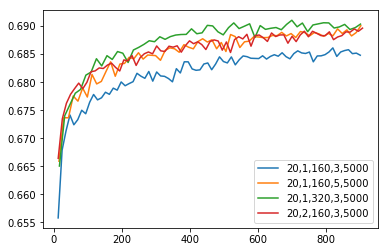

In [21]:
Plot(2, 'acc', '20,1,160,3,5000')
Plot(4, 'acc', '20,1,160,5,5000')
Plot(5, 'acc', '20,1,320,3,5000')
Plot(6, 'acc', '20,2,160,3,5000')
plt.legend();

In [22]:
fit(nUnitsPos = 50,nlayerPos = 3, nUnits = 640, nlayer = 8, batchSize = 5000, timelimit = 900)

Epoch 1/100
66s - loss: 0.6184 - acc: 0.6497 - val_loss: 0.6020 - val_acc: 0.6698
Epoch 2/100
65s - loss: 0.5980 - acc: 0.6741 - val_loss: 0.5970 - val_acc: 0.6766
Epoch 3/100
65s - loss: 0.5934 - acc: 0.6776 - val_loss: 0.5914 - val_acc: 0.6796
Epoch 4/100
65s - loss: 0.5900 - acc: 0.6804 - val_loss: 0.5887 - val_acc: 0.6810
Epoch 5/100
66s - loss: 0.5878 - acc: 0.6821 - val_loss: 0.5944 - val_acc: 0.6797
Epoch 6/100
67s - loss: 0.5857 - acc: 0.6835 - val_loss: 0.5878 - val_acc: 0.6811
Epoch 7/100
67s - loss: 0.5837 - acc: 0.6851 - val_loss: 0.5856 - val_acc: 0.6832
Epoch 8/100
67s - loss: 0.5819 - acc: 0.6866 - val_loss: 0.5852 - val_acc: 0.6841
Epoch 9/100
67s - loss: 0.5800 - acc: 0.6879 - val_loss: 0.5839 - val_acc: 0.6852
Epoch 10/100
67s - loss: 0.5781 - acc: 0.6893 - val_loss: 0.5837 - val_acc: 0.6857
Epoch 11/100
67s - loss: 0.5762 - acc: 0.6907 - val_loss: 0.5822 - val_acc: 0.6866
Epoch 12/100
67s - loss: 0.5746 - acc: 0.6912 - val_loss: 0.5818 - val_acc: 0.6869
Epoch 13/100


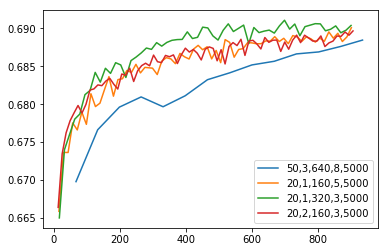

In [23]:
Plot(7, 'acc', '50,3,640,8,5000')
Plot(4, 'acc', '20,1,160,5,5000')
Plot(5, 'acc', '20,1,320,3,5000')
Plot(6, 'acc', '20,2,160,3,5000')
plt.legend();

In [24]:
fit(nUnitsPos = 20,nlayerPos = 2, nUnits = 320, nlayer = 5, batchSize = 5000, timelimit = 900)

Epoch 1/100
23s - loss: 0.6193 - acc: 0.6489 - val_loss: 0.6020 - val_acc: 0.6699
Epoch 2/100
22s - loss: 0.5973 - acc: 0.6745 - val_loss: 0.5955 - val_acc: 0.6757
Epoch 3/100
21s - loss: 0.5923 - acc: 0.6785 - val_loss: 0.5926 - val_acc: 0.6789
Epoch 4/100
22s - loss: 0.5895 - acc: 0.6809 - val_loss: 0.5910 - val_acc: 0.6782
Epoch 5/100
22s - loss: 0.5870 - acc: 0.6828 - val_loss: 0.5876 - val_acc: 0.6823
Epoch 6/100
21s - loss: 0.5854 - acc: 0.6842 - val_loss: 0.5862 - val_acc: 0.6838
Epoch 7/100
21s - loss: 0.5840 - acc: 0.6849 - val_loss: 0.5869 - val_acc: 0.6830
Epoch 8/100
21s - loss: 0.5824 - acc: 0.6861 - val_loss: 0.5842 - val_acc: 0.6845
Epoch 9/100
21s - loss: 0.5814 - acc: 0.6869 - val_loss: 0.5831 - val_acc: 0.6860
Epoch 10/100
21s - loss: 0.5801 - acc: 0.6878 - val_loss: 0.5835 - val_acc: 0.6860
Epoch 11/100
21s - loss: 0.5788 - acc: 0.6886 - val_loss: 0.5825 - val_acc: 0.6868
Epoch 12/100
21s - loss: 0.5776 - acc: 0.6895 - val_loss: 0.5838 - val_acc: 0.6858
Epoch 13/100


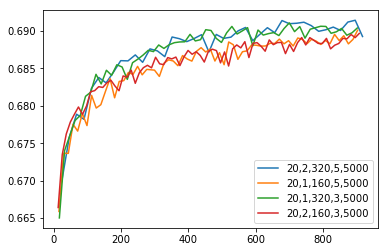

In [38]:
Plot(8, 'acc', '20,2,320,5,5000')
Plot(4, 'acc', '20,1,160,5,5000')
Plot(5, 'acc', '20,1,320,3,5000')
Plot(6, 'acc', '20,2,160,3,5000')
plt.legend();

In [34]:
refit(5000, 900, 5, 10)

Epoch 1/200
16s - loss: 0.5488 - acc: 0.7085 - val_loss: 0.5850 - val_acc: 0.6886
Epoch 2/200
16s - loss: 0.5481 - acc: 0.7086 - val_loss: 0.5842 - val_acc: 0.6899
Epoch 3/200
16s - loss: 0.5477 - acc: 0.7091 - val_loss: 0.5870 - val_acc: 0.6888
Epoch 4/200
16s - loss: 0.5472 - acc: 0.7093 - val_loss: 0.5860 - val_acc: 0.6890
Epoch 5/200
16s - loss: 0.5467 - acc: 0.7095 - val_loss: 0.5866 - val_acc: 0.6896
Epoch 6/200
15s - loss: 0.5460 - acc: 0.7102 - val_loss: 0.5869 - val_acc: 0.6893
Epoch 7/200
15s - loss: 0.5456 - acc: 0.7103 - val_loss: 0.5870 - val_acc: 0.6882
Epoch 8/200
15s - loss: 0.5452 - acc: 0.7104 - val_loss: 0.5873 - val_acc: 0.6888
Epoch 9/200
15s - loss: 0.5446 - acc: 0.7109 - val_loss: 0.5865 - val_acc: 0.6901
Epoch 10/200
15s - loss: 0.5441 - acc: 0.7111 - val_loss: 0.5879 - val_acc: 0.6895
Epoch 11/200
15s - loss: 0.5435 - acc: 0.7116 - val_loss: 0.5894 - val_acc: 0.6887
Epoch 12/200
15s - loss: 0.5431 - acc: 0.7118 - val_loss: 0.5889 - val_acc: 0.6894
Epoch 13/200


In [35]:
refit(5000, 900, 8, 10)

Epoch 1/200
21s - loss: 0.5445 - acc: 0.7107 - val_loss: 0.5875 - val_acc: 0.6910
Epoch 2/200
21s - loss: 0.5434 - acc: 0.7112 - val_loss: 0.5902 - val_acc: 0.6899
Epoch 3/200
21s - loss: 0.5426 - acc: 0.7115 - val_loss: 0.5896 - val_acc: 0.6898
Epoch 4/200
21s - loss: 0.5415 - acc: 0.7122 - val_loss: 0.5904 - val_acc: 0.6904
Epoch 5/200
21s - loss: 0.5406 - acc: 0.7129 - val_loss: 0.5926 - val_acc: 0.6911
Epoch 6/200
21s - loss: 0.5396 - acc: 0.7134 - val_loss: 0.5904 - val_acc: 0.6901
Epoch 7/200
21s - loss: 0.5388 - acc: 0.7139 - val_loss: 0.5945 - val_acc: 0.6901
Epoch 8/200
21s - loss: 0.5378 - acc: 0.7144 - val_loss: 0.5958 - val_acc: 0.6888
Epoch 9/200
21s - loss: 0.5371 - acc: 0.7149 - val_loss: 0.5953 - val_acc: 0.6903
Epoch 10/200
21s - loss: 0.5360 - acc: 0.7157 - val_loss: 0.5974 - val_acc: 0.6890
Epoch 11/200
22s - loss: 0.5354 - acc: 0.7159 - val_loss: 0.5963 - val_acc: 0.6899
Epoch 12/200
21s - loss: 0.5341 - acc: 0.7166 - val_loss: 0.6000 - val_acc: 0.6886


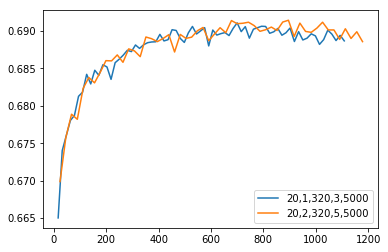

In [40]:
Plot2(5, 0, label = '20,1,320,3,5000')
Plot2(8, 1, label = '20,2,320,5,5000')
plt.legend();

# Do only lightning 
num_cause = 2

### Already done, do not do again

In [57]:
weatherData = np.concatenate((np.load('weatherData1991.npy'),np.load('FullweatherData.npy'),np.load('weatherData2000_04.npy'),
                             np.load('weatherData2005_09.npy'),np.load('weatherData2010_15.npy')))
df = pd.DataFrame(np.load('NewFireData.npy'), columns=['day', 'lat', 'lon', 'num_cause', 'tarray', 'xybinarray', 'fire'])
df = df[df['num_cause'] == 2 ].drop('num_cause',axis=1).astype(int, copy=False)

# Need to create new fake fires since the fake fire don't have the good distribution.
# There is no fake_fire in df because fake_fire don't have 'num_cause'
loc = np.load('FullLocData.npy')
ix = loc[:,0]
iy = loc[:,1]
nx, ny = 140, 62 # Need to be the same as when I produced FullLocData.npy
ybin = np.linspace(0,621,ny, dtype=int)
xbin = np.linspace(0,1405,nx, dtype=int)
yloc = ybin[iy]
xloc = xbin[ix]
xtobin = {}
prevx = xloc[0]
istart = 0
for i, x in enumerate(xloc[1:]):
    if x != prevx:
        xtobin[prevx] = (istart, i)
        istart = i+1
    prevx = x
xtobin[prevx] = (istart, len(xloc)-1)

def binarysearch(lon,xbin,beg,end):
    if beg == end:
        return xtobin[xbin[beg]]
    if beg == end-1 and lon < xbin[end]:
        return xtobin[xbin[beg]]
    center = (beg+end)//2
    value = xbin[center]
    if lon >= value:
        return binarysearch(lon,xbin,center,end)
    return binarysearch(lon,xbin,beg,center)
    
def binarysearch2(lon,xbin,beg,end):
    if beg == end:
        return beg
    if beg == end-1:
        if lon == xbin[end]:
            return end
        return beg
    center = (beg+end)//2
    value = xbin[center]
    if lon >= value:
        return binarysearch2(lon,xbin,center,end)
    return binarysearch2(lon,xbin,beg,center)

def findxybin(lon,lat):
    beg, end = binarysearch(lon,xbin,0,len(xbin)-1)
    if lat > yloc[end]:
        return end
    return binarysearch2(lat,yloc,beg,end)

def createfake(firepredict):
    affine2,affine0,affine5,affine4 = -125.02083333333333, 0.04166666666667, 49.93750000000203, -0.04166666666667
    s = len(firepredict)
    lonlat = firepredict[['lon','lat']].sample(n=s,replace=True).reset_index(drop=True)
    t = firepredict['tarray'].sample(n=s,replace=True).reset_index(drop=True)
    fakefire = lonlat.join(t)

    fakefire['day'] = fakefire['tarray'].apply(lambda x: (pd.Timedelta(x,'D') + pd.to_datetime('1992-01-01')).dayofyear)

    # get xybin
    lonarray = (fakefire['lon'].values - affine2)//affine0
    latarray = (fakefire['lat'].values - affine5)//affine4
    fakefire['xybinarray'] = np.vectorize(findxybin,otypes=[int])(lonarray,latarray)

    # align columns
    firepredict, fakefire = firepredict.align(fakefire,axis=1,copy=False)
    
    fakefire['fire']=False
    firepredict['fire']=True
    return pd.concat([fakefire,firepredict])

df = createfake(df)

# ________________________________________________
def moddf(df):
    df0 = df.drop(['tarray', 'xybinarray'],axis=1).values
    df0 = (df0-df0.mean())/ df0.std()
    
    tarray = df['tarray'].values
    xybinarray = df['xybinarray'].values
    df1 = np.empty((len(df),31,4))
    for i in range(0,31):
        for j in range(0,4):
            df1[:,i,j] = weatherData[tarray-i, xybinarray,j]
    # Normalize features
    df1 = (df1-df1.mean())/ df1.std()
    
    return df0, df1

xdf = df.drop('fire',axis=1)
y = df['fire'].values
x0, x1 = moddf(xdf)
X0, X0_test, X1, X1_test, y, y_test = train_test_split(
    x0, x1, y, test_size=0.1, shuffle=True)
X0_train, X0_val, X1_train, X1_val, y_train, y_val = train_test_split(
    X0, X1, y, test_size=0.1, shuffle=True)

np.save('X0_trainL', X0_train, allow_pickle=True, fix_imports=False)
np.save('X1_trainL', X1_train, allow_pickle=True, fix_imports=False)
np.save('y_trainL', y_train, allow_pickle=True, fix_imports=False)
np.save('X0_valL', X0_val, allow_pickle=True, fix_imports=False)
np.save('X1_valL', X1_val, allow_pickle=True, fix_imports=False)
np.save('y_valL', y_val, allow_pickle=True, fix_imports=False)
np.save('X0_testL', X0_test, allow_pickle=True, fix_imports=False)
np.save('X1_testL', X1_test, allow_pickle=True, fix_imports=False)
np.save('y_testL', y_test, allow_pickle=True, fix_imports=False)

### Load data

In [ ]:
X0_train = np.load('X0_trainL.npy', mmap_mode='r')
X1_train = np.load('X1_trainL.npy', mmap_mode='r')
y_train = np.load('y_trainL.npy', mmap_mode='r')
X0_val = np.load('X0_valL.npy')
X1_val = np.load('X1_valL.npy')
y_val = np.load('y_valL.npy')
X0_test = np.load('X0_testL.npy')
X1_test = np.load('X1_testL.npy')
y_test = np.load('y_testL.npy')

length_train = X0_train.shape[1]
print(length_train)
indices = np.arange(length_train, dtype=int)

In [58]:
def generator(batchSize=512):
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(indices), batchSize):
            batch_indices = indices[i:i+batchSize]
            batch_indices.sort()

            bx0 = X0_train[batch_indices,...]
            bx1 = X1_train[batch_indices,...]
            by = y_train[batch_indices,...]

            yield ([bx0,bx1], by)

### Train neuronet (GRU)

In [59]:
def fit(nUnits, batchSize, timelimit, nlayer, nlayer2):
    x0 = Input(shape=(3,)) # location and day
    x1 = Input(shape=(31,4)) # weather
    # first
    inistate = Dense(nUnits, activation = 'relu')(x0)
    x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
    # nlayer middle layers
    for _ in range(nlayer): 
        inistate = Dense(nUnits, activation = 'relu')(inistate)
        x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
    # last
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = Concatenate()([x,inistate])
    for _ in range(nlayer2): 
        x = Dense(nUnits, activation = 'relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[x0,x1], outputs=x)
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit_generator(generator(batchSize),steps_per_epoch = length_train//batchSize
                                        ,epochs=100, verbose=2, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping]))
    xaxis.append(time_callback.times)
    modelList.append(model) 
    
def refit(batchsize, timelimit, model, patience):
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    es = EarlyStopping(monitor='val_loss', min_delta=0., patience=patience)
    refit_history.append(modelList[model].fit_generator(generator(batchsize),steps_per_epoch = 2973745//batchsize
                                        ,epochs=200, verbose=2, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping, es]))
    refit_xaxis.append(time_callback.times)

In [61]:
fit(nUnits = 80, batchSize = 1024, timelimit = 300, nlayer = 1, nlayer2 = 1)

Epoch 1/100
49s - loss: 0.6777 - acc: 0.5607 - val_loss: 0.6662 - val_acc: 0.5817
Epoch 2/100
48s - loss: 0.6581 - acc: 0.5952 - val_loss: 0.6503 - val_acc: 0.6036
Epoch 3/100
45s - loss: 0.6498 - acc: 0.6086 - val_loss: 0.6439 - val_acc: 0.6094
Epoch 4/100
45s - loss: 0.6406 - acc: 0.6205 - val_loss: 0.6353 - val_acc: 0.6232
Epoch 5/100
45s - loss: 0.6381 - acc: 0.6245 - val_loss: 0.6365 - val_acc: 0.6245
Epoch 6/100
45s - loss: 0.6335 - acc: 0.6269 - val_loss: 0.6301 - val_acc: 0.6312
Epoch 7/100
44s - loss: 0.6339 - acc: 0.6257 - val_loss: 0.6330 - val_acc: 0.6247


In [62]:
fit(nUnits = 160, batchSize = 1024, timelimit = 300, nlayer = 1, nlayer2 = 1)

Epoch 1/100
86s - loss: 0.6767 - acc: 0.5588 - val_loss: 0.6640 - val_acc: 0.5863
Epoch 2/100
83s - loss: 0.6560 - acc: 0.5971 - val_loss: 0.6444 - val_acc: 0.6167
Epoch 3/100
83s - loss: 0.6460 - acc: 0.6126 - val_loss: 0.6413 - val_acc: 0.6175
Epoch 4/100
83s - loss: 0.6412 - acc: 0.6180 - val_loss: 0.6384 - val_acc: 0.6190


In [63]:
fit(nUnits = 80, batchSize = 1024, timelimit = 300, nlayer = 2, nlayer2 = 1)

Epoch 1/100
63s - loss: 0.6789 - acc: 0.5580 - val_loss: 0.6644 - val_acc: 0.5834
Epoch 2/100
59s - loss: 0.6567 - acc: 0.5977 - val_loss: 0.6510 - val_acc: 0.6025
Epoch 3/100
59s - loss: 0.6472 - acc: 0.6094 - val_loss: 0.6428 - val_acc: 0.6149
Epoch 4/100
59s - loss: 0.6467 - acc: 0.6130 - val_loss: 0.6389 - val_acc: 0.6233
Epoch 5/100
59s - loss: 0.6411 - acc: 0.6190 - val_loss: 0.6372 - val_acc: 0.6213


In [64]:
fit(nUnits = 80, batchSize = 1024, timelimit = 300, nlayer = 1, nlayer2 = 2)

Epoch 1/100
49s - loss: 0.6802 - acc: 0.5548 - val_loss: 0.6686 - val_acc: 0.5654
Epoch 2/100
45s - loss: 0.6632 - acc: 0.5867 - val_loss: 0.6536 - val_acc: 0.6005
Epoch 3/100
45s - loss: 0.6505 - acc: 0.6069 - val_loss: 0.6473 - val_acc: 0.6084
Epoch 4/100
45s - loss: 0.6441 - acc: 0.6155 - val_loss: 0.6376 - val_acc: 0.6225
Epoch 5/100
45s - loss: 0.6399 - acc: 0.6207 - val_loss: 0.6378 - val_acc: 0.6224
Epoch 6/100
45s - loss: 0.6380 - acc: 0.6225 - val_loss: 0.6331 - val_acc: 0.6300
Epoch 7/100
45s - loss: 0.6315 - acc: 0.6299 - val_loss: 0.6286 - val_acc: 0.6268


In [68]:
print(len(df))

548698


Now, it's only for the fires due to lightning. One might expect to get a better accuracy due to the lightning fires being more
related to weather, but on the other hand, there is much less data. Only 548698 rather than 1.88 million, only 29%.

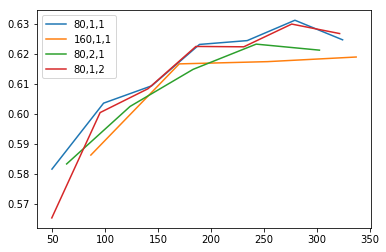

In [70]:
Plot(0, 'acc', '80,1,1')
Plot(1, 'acc', '160,1,1')
Plot(2, 'acc', '80,2,1')
Plot(3, 'acc', '80,1,2')
plt.legend();